In [39]:
import sys
sys.path.insert(0, 'utils')
from matplotlib.font_manager import FontProperties
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
import ds_charts as ds
from ds_charts import plot_evaluation_results
import itertools as it
import timeit
import os



%matplotlib inline

In [67]:

dataset = 'gccd'
suffix = 'gccd_dankfe3'
file_name = ''

data_dir = f'data/{dataset}/'
image_dir = f'images/{dataset}/{suffix}/'

if not os.path.exists(data_dir):
        os.mkdir(data_dir)
if not os.path.exists(image_dir):
        os.mkdir(image_dir)

train_test_avaliable = True

if train_test_avaliable:
        train = pd.read_csv(f'{data_dir}{file_name}{suffix}_train.csv',parse_dates=['current_date'], infer_datetime_format=True)
        test = pd.read_csv(f'{data_dir}{file_name}{suffix}_test.csv',parse_dates=['current_date'], infer_datetime_format=True)
else:
        train = pd.read_csv(f'{data_dir}{file_name}{suffix}.csv',parse_dates=['current_date'], infer_datetime_format=True)

In [70]:
# Tratamento de missing values

le = LabelEncoder()

# train = train.drop(columns=['ratio'])
# train = train.dropna(subset=['high_risk_2w'])
# train = train.dropna(subset=['renewable_percentage'])

variable_types = ds.get_variable_types(train)
print(variable_types)

train = train.drop(columns=variable_types['Date'])
train['country'] = le.fit_transform(train['country'])
train['city'] = le.fit_transform(train['city'])
# train['weapon'] = le.fit_transform(train['weapon'])
# train['district'] = le.fit_transform(train['district'])
# train['neighborhood'] = le.fit_transform(train['neighborhood'])
# train['description'] = le.fit_transform(train['description'])
train = train.dropna(subset=['last_year_temp'])
train = train.dropna(subset=['one_year_diff'])
print(train.isna().sum()[train.isna().sum() != 0])
print(train.iloc[0])

if train_test_avaliable:
    test = test.drop(columns=variable_types['Date'])
    test['country'] = le.fit_transform(test['country'])
    test['city'] = le.fit_transform(test['city'])
    # test['weapon'] = le.fit_transform(test['weapon'])
    # test['district'] = le.fit_transform(test['district'])
    # test['description'] = le.fit_transform(test['description'])
    # train['neighborhood'] = le.fit_transform(train['neighborhood'])
    # test['neighborhood'] = le.fit_transform(test['neighborhood'])
    test = test.dropna(subset=['last_year_temp'])
    test = test.dropna(subset=['one_year_diff'])
    print(test.isna().sum()[test.isna().sum() != 0])



{'Numeric': ['temperature', 'uncertainty', 'lat', 'lon', 'country_lat', 'country_lon', 'last_year_temp', 'one_year_diff', 'avg_temp_year', 'average_diff', 'current_date_day', 'current_date_month', 'current_date_year', 'current_date_season', 'current_date_weekday', 'temperature_mean_per_city', 'temperature_std_per_city', 'temperature_median_per_city', 'temperature_max_per_city', 'temperature_min_per_city', 'uncertainty_mean_per_city', 'uncertainty_std_per_city', 'uncertainty_median_per_city', 'uncertainty_max_per_city', 'uncertainty_min_per_city', 'temperature_mean_per_country', 'temperature_std_per_country', 'temperature_median_per_country', 'temperature_max_per_country', 'temperature_min_per_country', 'uncertainty_mean_per_country', 'uncertainty_std_per_country', 'uncertainty_median_per_country', 'uncertainty_max_per_country', 'uncertainty_min_per_country', 'city', 'country'], 'Binary': ['average_diff_pos'], 'Date': [], 'Symbolic': []}
Series([], dtype: int64)
temperature             

In [71]:
target = 'average_diff_pos'
positive = True
negative = False

if train_test_avaliable:
    trnY: np.ndarray = train.pop(target).values
    trnX: np.ndarray = train.values
    tstY: np.ndarray = test.pop(target).values
    tstX: np.ndarray = test.values
    labels: np.ndarray = pd.unique(trnY)
else:
    y = train.pop(target).values
    X = train.values
    labels: np.ndarray = pd.unique(y)

model_scores = {
    'NB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'KNN': {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'DT':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'RF':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'GB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
}

In [72]:
# TEST CONFIGURATIONS
train_config = {
    'KNN' : True,
    'DT' : True,
    'RF' : True,
    'GB' : True,
    'iterations' : 10,
}

times = {
    'NB' : {'fit': [], 'pred': []},
    'KNN' : {'fit': [], 'pred': [], 'param': []},
    'DT' : {'fit': [], 'pred': [], 'param': []},
    'RF' : {'fit': [], 'pred': [], 'param': []},
    'GB' : {'fit': [], 'pred': [], 'param': []},
}

model_importances = {
    'DT' : [],
    'RF' : [],
    'GB' : [],
}

In [73]:
def get_scores_fold(y_train,y_prediction,store,model):
    store[model]['precision'].append(metrics.precision_score(y_train,y_prediction))
    store[model]['recall'].append(metrics.recall_score(y_train,y_prediction))
    store[model]['accuracy'].append(metrics.accuracy_score(y_train,y_prediction))
    store[model]['auc'].append(metrics.roc_auc_score(y_train,y_prediction))
    store[model]['F1'].append(metrics.f1_score(y_train,y_prediction))
    return store

In [74]:
def get_best_params(model,params, X, y,iterations, train, model_name, suffix):
    accuracy_thres = 0.98
    f1_thres = 0.90
    if train == True:
        start_time = timeit.default_timer()
        param_combinations = [dict(zip(params.keys(), a)) for a in it.product(*params.values())]
        values = {}
        param_list = []
        for i in range(iterations):
            print(i, end= ' ')
            trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
            best = ()
            last_best = 0
            yvalues = []
            param_counter = 0
            for param_comb in param_combinations:
                param_counter += 1
                model = model.set_params(**param_comb)
                model.fit(trnX, trnY)
                prdY = model.predict(tstX)
                acc_result = metrics.accuracy_score(tstY, prdY)
                f1_result = metrics.f1_score(tstY, prdY)
                yvalues.append(acc_result)
                if acc_result >= accuracy_thres and f1_result >= f1_thres:
                    best = tuple(param_comb.values())
                    break
                if yvalues[-1] > last_best:
                    best = tuple(param_comb.values())
                    last_best = yvalues[-1]
            if best not in values:
                values[best] = [max(yvalues)]
            else:
                values[best] = values[best] + [max(yvalues)]
            param_list.append(param_counter)
        bestarg_values = [(key,len(value)) for key,value in values.items()]
        best = bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))][0]
        # print(bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))])
        # print(f"Average number of combinations per iteration: {round(np.mean(param_list))}")
        times[model_name]['param'] = timeit.default_timer() - start_time
        # print(f"Parameter time: {timeit.default_timer() - start_time}")
        return best
    else:
        print(f'Using best parameters: {best_parameters[model_name][0]}')
        return best_parameters[model_name][0]

def get_best_params_train_test(model,params, trnX, trnY, tstX, tstY ,iterations, train, model_name, suffix):
    accuracy_thres = 0.98
    f1_thres = 0.90
    if train == True:
        start_time = timeit.default_timer()
        param_combinations = [dict(zip(params.keys(), a)) for a in it.product(*params.values())]
        values = {}
        param_list = []
        for i in range(iterations):
            # print(i, end= ' ')
            # trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
            best = ()
            last_best = 0
            yvalues = []
            param_counter = 0
            for param_comb in param_combinations:
                param_counter += 1
                model = model.set_params(**param_comb)
                model.fit(trnX, trnY)
                prdY = model.predict(tstX)
                acc_result = metrics.accuracy_score(tstY, prdY)
                f1_result = metrics.f1_score(tstY, prdY)
                yvalues.append(acc_result)
                if acc_result >= accuracy_thres and f1_result >= f1_thres:
                    best = tuple(param_comb.values())
                    break
                if yvalues[-1] > last_best:
                    best = tuple(param_comb.values())
                    last_best = yvalues[-1]
            if best not in values:
                values[best] = [max(yvalues)]
            else:
                values[best] = values[best] + [max(yvalues)]
            param_list.append(param_counter)
        bestarg_values = [(key,len(value)) for key,value in values.items()]
        best = bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))][0]
        # print(bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))])
        # print(f"Average number of combinations per iteration: {round(np.mean(param_list))}")
        times[model_name]['param'] = timeit.default_timer() - start_time
        return best
    else:
        print(f'Using best parameters: {best_parameters[model_name][0]}')
        return best_parameters[model_name][0]

0 

zfit time: 0.29938290000063716
zpredict: 0.02883530000144674
1 zfit time: 0.04529209999964223
zpredict: 0.028776000001016655
2 zfit time: 0.0481978000007075
zpredict: 0.028887799999210984
3 zfit time: 0.3158478000004834
zpredict: 0.022942099998545018
4 zfit time: 0.04303599999911967
zpredict: 0.02295159999994212
5 zfit time: 0.15344349999941187
zpredict: 0.0292782000014995
6 zfit time: 0.037459999999555293
zpredict: 0.024734900000112248
7 zfit time: 0.06424889999834704
zpredict: 0.033859099999972386
8 zfit time: 0.04622699999890756
zpredict: 0.013453099998514517
9 zfit time: 0.04425759999867296
zpredict: 0.016966499999398366


<Figure size 600x450 with 0 Axes>

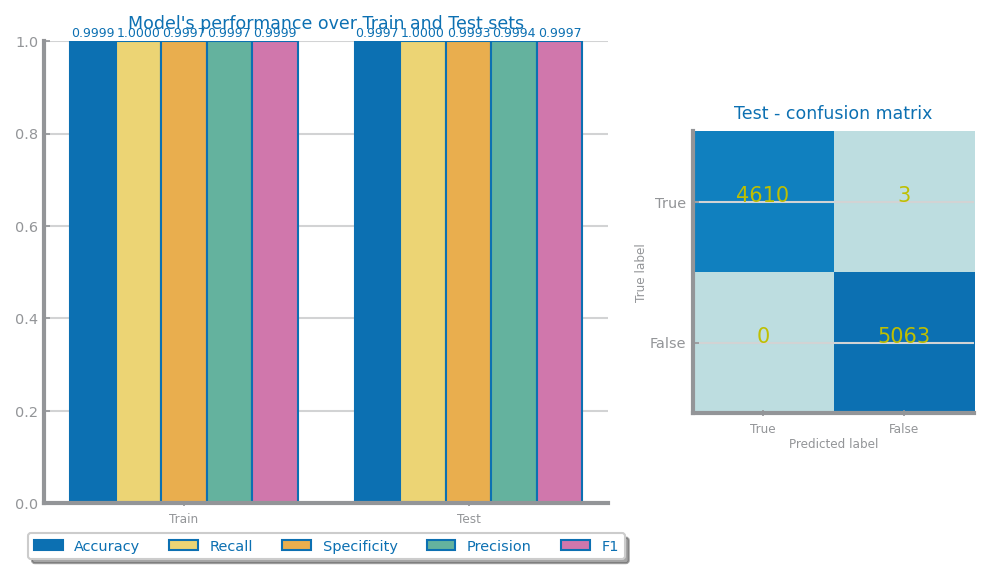

In [75]:
# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

iterations = train_config['iterations']

fit_time = []
pred_time = []
nb_train_predictions = []
nb_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_nb = BernoulliNB()
counter = 0
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
    start_time = timeit.default_timer()
    clf_nb.fit(trnX, trnY)
    times['NB']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_nb.predict(trnX)
    # print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_nb.predict(tstX)
    times['NB']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    nb_train_predictions.append(prd_trn)
    nb_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'NB')

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}NB.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.005183800001759664
train_predict time: 9.052647099999376
zpredict: 3.8392161000010674
1 zfit time: 0.003927799998564296
train_predict time: 8.68587370000023
zpredict: 3.8805873000001156
2 zfit time: 0.0038566000002902
train_predict time: 8.927397700001166
zpredict: 3.6326705000010406
3 zfit time: 0.0047325000014097895
train_predict time: 8.741645199999766
zpredict: 4.996354099999735
4 zfit time: 0.006265300000450225
train_predict time: 9.73429489999944
zpredict: 4.399806400000671
5 zfit time: 0.009336499999335501
train_predict time: 9.46477799999957
zpredict: 4.123651100000643
6 zfit time: 0.0037616999998135725
train_predict time: 8.965503600000375
zpredict: 4.083074399999532
7 zfit time: 0.004987000000255648
train_predict time: 9.410188600000765
zpredict: 4.255405699999756
8 zfit time: 0.0037183000004006317
train_predict time: 9.385149899999305
zpredict: 4.145295700000133
9 zfit time: 0.004775100000188104
train_predict time: 9.624743700000181
zpredict: 4.05161820000103


<Figure size 600x450 with 0 Axes>

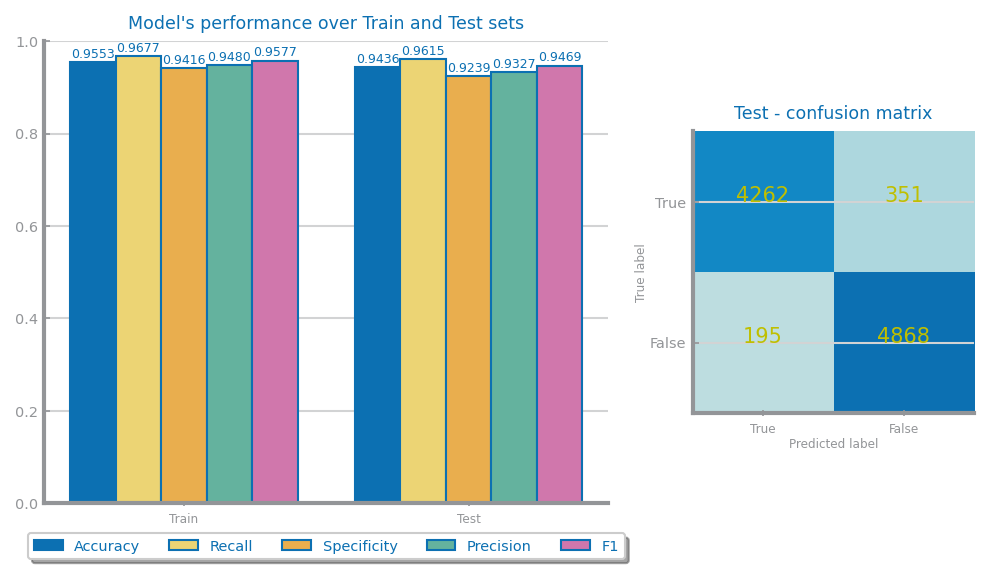

In [76]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
iterations = train_config['iterations']
params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'metric': ['manhattan', 'euclidean', 'chebyshev'],
}

model = KNeighborsClassifier(n_jobs=-1)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['KNN'], model_name='KNN', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['KNN'], model_name='KNN', suffix=suffix)

knn_train_predictions = []
knn_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1], n_jobs = -1)
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_knn.fit(trnX, trnY)
    times['KNN']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_knn.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_knn.predict(tstX)
    times['KNN']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    knn_train_predictions.append(prd_trn)
    knn_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'KNN')

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}knn.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.07864270000027318
train_predict time: 0.003736499998922227
zpredict: 0.001762800000506104
1 zfit time: 0.07098489999953017
train_predict time: 0.004373800000394112
zpredict: 0.004169600000750506
2 zfit time: 0.08039180000014312
train_predict time: 0.0034142999993491685
zpredict: 0.0017846999999164836
3 zfit time: 0.08508380000057514
train_predict time: 0.005012999999962631
zpredict: 0.0025925999998435145
4 zfit time: 0.08792770000036398
train_predict time: 0.00523570000041218
zpredict: 0.003894600000421633
5 zfit time: 0.07731980000062322
train_predict time: 0.0040536000014981255
zpredict: 0.001527999998870655
6 zfit time: 0.08941159999994852
train_predict time: 0.0029786000013700686
zpredict: 0.0017346999993606005
7 zfit time: 0.06960279999839258
train_predict time: 0.0057279000011476455
zpredict: 0.0028108999995311024
8 zfit time: 0.08368159999918134
train_predict time: 0.0037957000004098518
zpredict: 0.0021178999995754566
9 zfit time: 0.07942390000062005
train_predict

<Figure size 600x450 with 0 Axes>

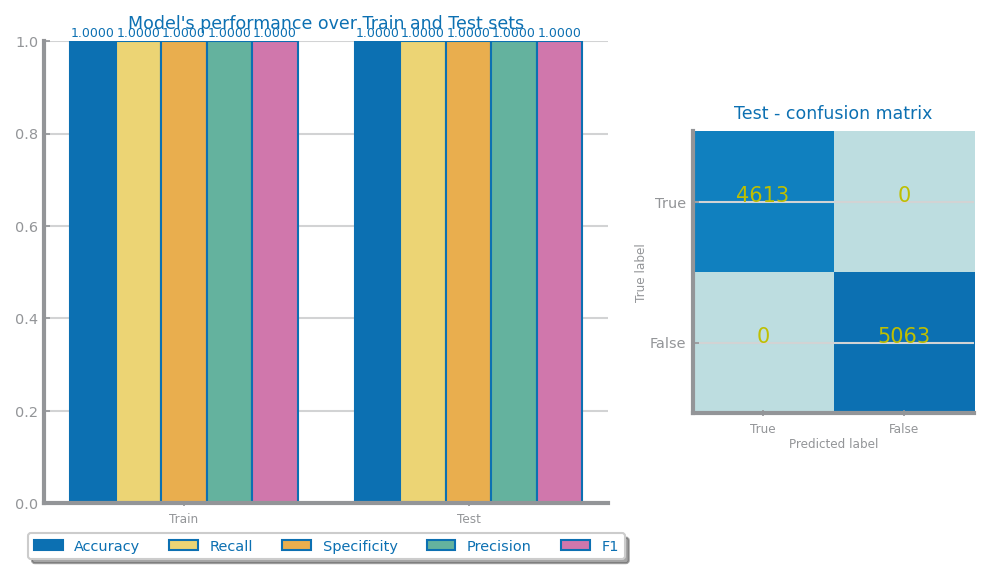

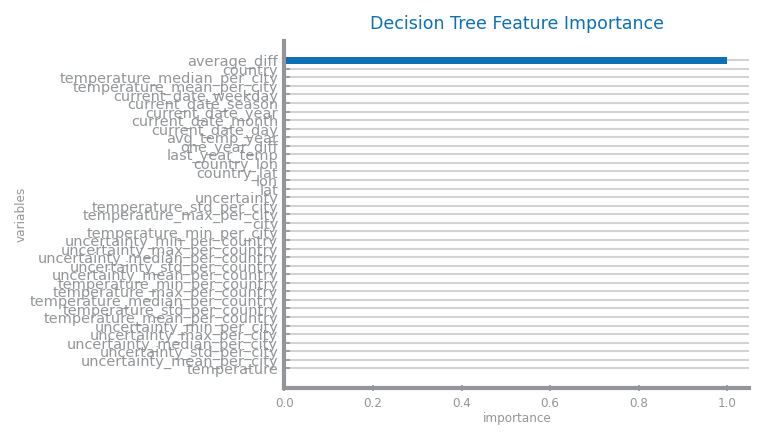

In [77]:
#  DECISION TREE
from sklearn.tree import DecisionTreeClassifier, plot_tree
iterations = train_config['iterations']
params = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.025, 0.01, 0.005, 0.0025, 0.001],
    'max_depth': [2, 5, 10, 15, 20, 25],
}

model = DecisionTreeClassifier(random_state = 0)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['DT'], model_name='DT', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['DT'], model_name='DT', suffix=suffix)

dt_train_predictions = []
dt_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_dt = DecisionTreeClassifier(criterion=best[0],min_impurity_decrease=best[1],max_depth=best[2],random_state=0)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_dt.fit(trnX, trnY)
    times['DT']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_dt.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_dt.predict(tstX)
    times['DT']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    dt_train_predictions.append(prd_trn)
    dt_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'DT')

    # plot_tree(clf_dt, feature_names=data.columns, class_names=['0','1'])
    # plt.savefig(f'{image_dir}dt/fold_{counter}_best_tree.png', dpi=300, bbox_inches='tight')

    variables = train.columns
    importances = clf_dt.feature_importances_
    importance_list.append(importances)
    # std = np.std([tree.feature_importances_ for tree in clf_dt.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}DT.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]

model_importances['DT'] = list(zip(elems,mean_importance[indices]))

fig = plt.figure()
ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Decision Tree Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}dt_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.08731770000122197
train_predict time: 0.023351899999397574
zpredict: 0.018877599999541417
1 zfit time: 0.10502730000007432
train_predict time: 0.03660409999974945
zpredict: 0.024698600000192528
2 zfit time: 0.10586419999890495
train_predict time: 0.03873080000084883
zpredict: 0.03395780000028026
3 zfit time: 0.10528339999837044
train_predict time: 0.040397199998551514
zpredict: 0.023245399999723304
4 zfit time: 0.10192709999864746
train_predict time: 0.02660470000046189
zpredict: 0.028153700000984827
5 zfit time: 0.08575749999909021
train_predict time: 0.030612399999881745
zpredict: 0.021192700000028708
6 zfit time: 0.07150189999993017
train_predict time: 0.02356560000043828
zpredict: 0.02041529999951308
7 zfit time: 0.11560959999951592
train_predict time: 0.043423900000561844
zpredict: 0.04815679999956046
8 zfit time: 0.08493070000076841
train_predict time: 0.022206999999980326
zpredict: 0.03214800000023388
9 zfit time: 0.06518270000015036
train_predict time: 0.02522560

<Figure size 600x450 with 0 Axes>

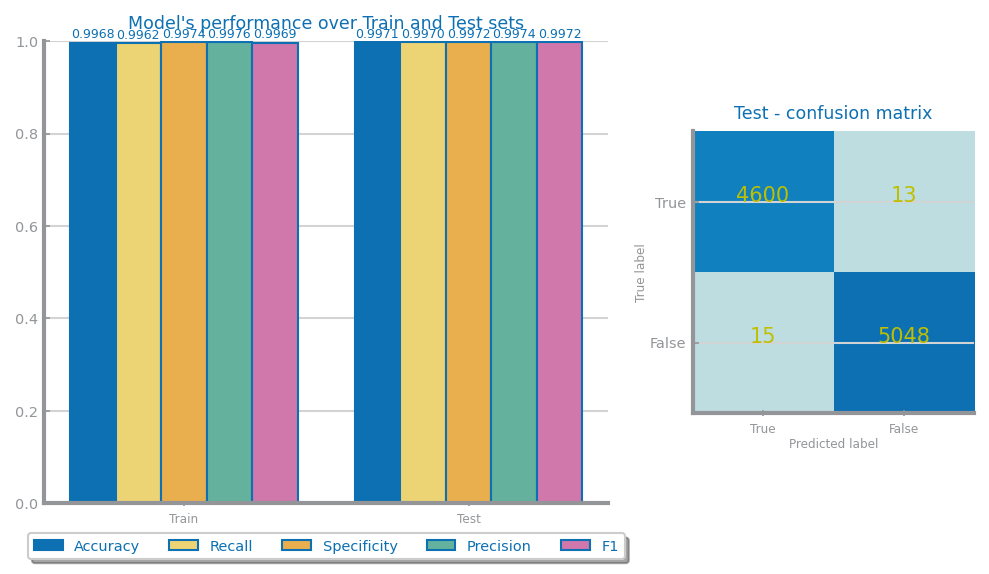

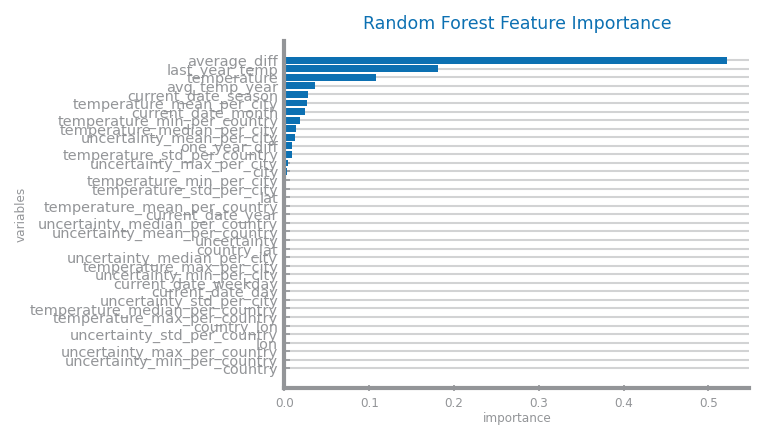

In [78]:
#  RANDOM FOREST

iterations = train_config['iterations']
params = {
    'max_depth' : [5,10,15],
    'max_features' : [.1, .3, .5, .7, .9, 1.0],
    'n_estimators' : [5, 10, 25, 50, 75, 100, 150],
}

model = RandomForestClassifier(random_state = 0, n_jobs = -1)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['RF'], model_name='RF', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['RF'], model_name='RF', suffix=suffix)

rf_train_predictions = []
rf_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_rf = RandomForestClassifier(max_depth=best[0],max_features=best[1],n_estimators=best[2],random_state=0, n_jobs=-1)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_rf.fit(trnX, trnY)
    times['RF']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_rf.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_rf.predict(tstX)
    times['RF']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    rf_train_predictions.append(prd_trn)
    rf_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'RF')

    variables = train.columns
    importances = clf_rf.feature_importances_
    importance_list.append(importances)
    std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]
        # print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

    fig = plt.figure()
    ds.horizontal_bar_chart(elems, importances[indices], std[indices], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
    # plt.savefig(f'{image_dir}rf/seed_{counter}_rf_ranking.png', dpi=300, bbox_inches = 'tight')
    plt.close(fig)

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}rf.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]

model_importances['RF'] = list(zip(elems,mean_importance[indices]))

fig = plt.figure()
ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Random Forest Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}RF_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.6075605999994877
train_predict time: 0.030285499999081367
zpredict: 0.014943199999834178
1 zfit time: 0.5612861999998131
train_predict time: 0.017520299999887357
zpredict: 0.0065288000005239155
2 zfit time: 0.5950628999999026
train_predict time: 0.006678399999145768
zpredict: 0.0028698000005533686
3 zfit time: 0.3416633000015281
train_predict time: 0.010269599999446655
zpredict: 0.0053670999986934476
4 zfit time: 0.37627340000108234
train_predict time: 0.007603699999890523
zpredict: 0.002799200001391
5 zfit time: 0.4095299000000523
train_predict time: 0.006491600001027109
zpredict: 0.0027305000003252644
6 zfit time: 0.4187268000005133
train_predict time: 0.012115400000766385
zpredict: 0.0036522999998851446
7 zfit time: 0.363619200001267
train_predict time: 0.006744199999957345
zpredict: 0.0047884000014164485
8 zfit time: 0.30826019999949494
train_predict time: 0.005957499999567517
zpredict: 0.0030203999995137565
9 zfit time: 0.36442279999937455
train_predict time: 0.0069

<Figure size 600x450 with 0 Axes>

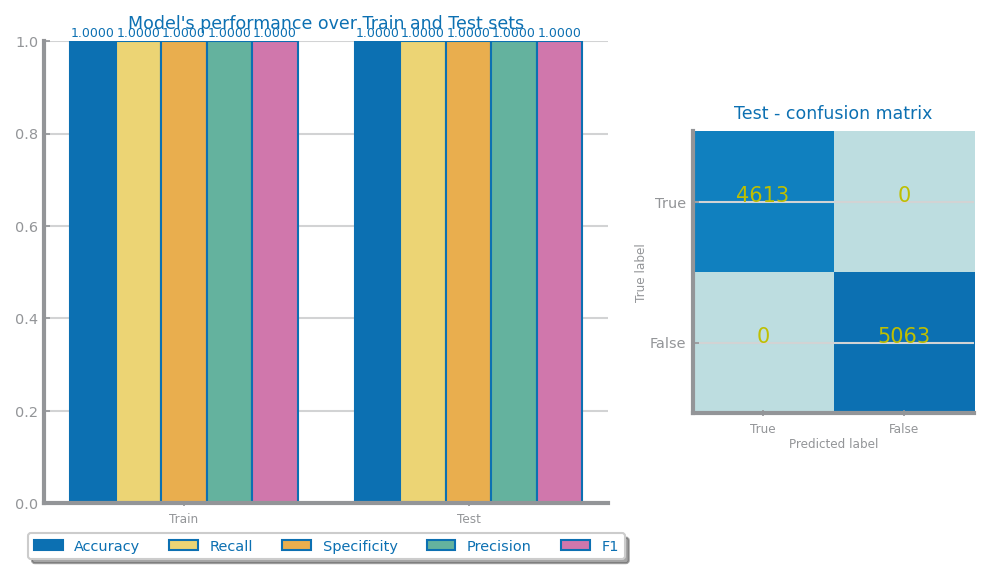

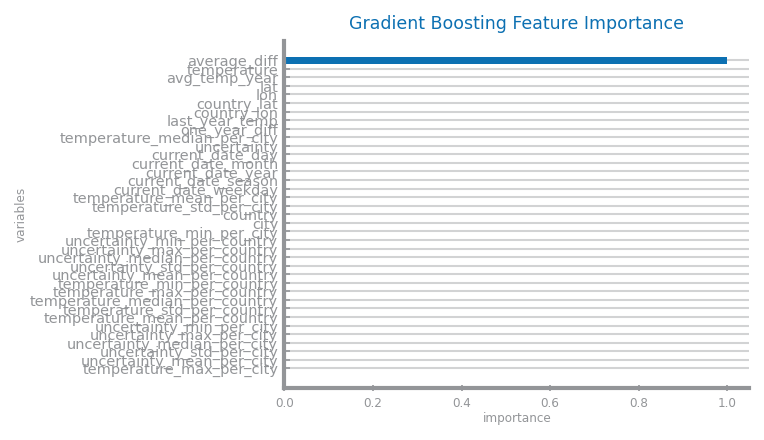

In [79]:
#  Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

iterations = train_config['iterations']

params = {
    'n_estimators' : [5, 10, 25, 50, 75, 100, 200],
    'max_depth' : [5, 10, 25],
    'learning_rate' : [.1, .5, .9]
}

model = GradientBoostingClassifier(random_state = 0)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['GB'], model_name='GB', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['GB'], model_name='GB', suffix=suffix)

gb_train_predictions = []
gb_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_gb = GradientBoostingClassifier(n_estimators=best[0], max_depth=best[1], learning_rate=best[2], random_state = 0)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_gb.fit(trnX, trnY)
    times['GB']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_gb.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_gb.predict(tstX)
    times['GB']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    gb_train_predictions.append(prd_trn)
    gb_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'GB')

    variables = train.columns
    importances = clf_gb.feature_importances_
    importance_list.append(importances)
    # std = np.std([tree.feature_importances_ for tree in clf_gb.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]
        # print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

    fig = plt.figure()
    ds.horizontal_bar_chart(elems, importances[indices], np.std(importance_list),title='Gradient Boosting Features importance', xlabel='importance', ylabel='variables')
    # plt.savefig(f'{image_dir}gb/seed_{counter}_gb_ranking.png', dpi=300, bbox_inches = 'tight')
    plt.close(fig)

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}gb.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]
fig = plt.figure()

model_importances['GB'] = list(zip(elems,mean_importance[indices]))

ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Gradient Boosting Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}GB_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

In [80]:
scores = {
    'NB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'KNN': {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'DT':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'RF':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'GB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
}
for i,v in model_scores.items():
    for m,v2 in v.items():
        mean = np.mean(v2)
        scores[i][m] = mean
print(scores)

{'NB': {'precision': 0.9994078168180025, 'recall': 1.0, 'accuracy': 0.9996899545266638, 'auc': 0.9996748319965315, 'F1': 0.9997038207128048}, 'KNN': {'precision': 0.9327457367311747, 'recall': 0.9614852854039107, 'accuracy': 0.9435717238528317, 'auc': 0.9426979862961458, 'F1': 0.9468974907605524}, 'DT': {'precision': 1.0, 'recall': 1.0, 'accuracy': 1.0, 'auc': 1.0, 'F1': 1.0}, 'RF': {'precision': 0.9974313376803003, 'recall': 0.9970373296464545, 'accuracy': 0.997106242248863, 'auc': 0.9971096034748642, 'F1': 0.9972342947451599}, 'GB': {'precision': 1.0, 'recall': 1.0, 'accuracy': 1.0, 'auc': 1.0, 'F1': 1.0}}


In [81]:
scores_n = {'precision' : [], 'recall' : [], 'accuracy' : [], 'auc' : [], 'F1' : []}

for k,v in scores.items():
    print(k,v)
    scores_n['precision'].append(v['precision'])
    scores_n['recall'].append(v['recall'])
    scores_n['accuracy'].append(v['accuracy'])
    scores_n['auc'].append(v['auc'])
    scores_n['F1'].append(v['F1'])

for v in scores_n.values():
    for i in v:
        print(i)

print()

for model_name, model_time in times.items():
    for operation, time_list in model_time.items():
        if operation != 'param':
            # print(model_name,operation)
            print(np.mean(time_list))

print() 

for model_name, model_time in times.items():
    for operation, time_list in model_time.items():
        if operation == 'param':
            # print(model_name,operation)
            print(np.mean(time_list))

print()

print(model_importances)

NB {'precision': 0.9994078168180025, 'recall': 1.0, 'accuracy': 0.9996899545266638, 'auc': 0.9996748319965315, 'F1': 0.9997038207128048}
KNN {'precision': 0.9327457367311747, 'recall': 0.9614852854039107, 'accuracy': 0.9435717238528317, 'auc': 0.9426979862961458, 'F1': 0.9468974907605524}
DT {'precision': 1.0, 'recall': 1.0, 'accuracy': 1.0, 'auc': 1.0, 'F1': 1.0}
RF {'precision': 0.9974313376803003, 'recall': 0.9970373296464545, 'accuracy': 0.997106242248863, 'auc': 0.9971096034748642, 'F1': 0.9972342947451599}
GB {'precision': 1.0, 'recall': 1.0, 'accuracy': 1.0, 'auc': 1.0, 'F1': 1.0}
0.9994078168180025
0.9327457367311747
1.0
0.9974313376803003
1.0
1.0
0.9614852854039107
1.0
0.9970373296464545
1.0
0.9996899545266638
0.9435717238528317
1.0
0.997106242248863
1.0
0.9996748319965315
0.9426979862961458
1.0
0.9971096034748642
1.0
0.9997038207128048
0.9468974907605524
1.0
0.9972342947451599
1.0

0.10973622999990766
0.025063910000062604
0.005052219999925001
4.140764910000326
0.0802440100002

In [193]:
# a = pd.DataFrame(model_scores).reset_index()
# b = pd.melt(a, id_vars="index", var_name="model", value_name="score")
# c = b.explode('score')

# darkblue = '#0C70B2'


# plt.figure(figsize=(7.5,3))
# ax = sns.barplot(x='index', y='score', hue='model', data=c, ci = 'sd', errwidth=1, edgecolor = darkblue)
# ax.set_title('Baseline Model Scores')
# for i in range(len(ax.containers)):
#     ax.bar_label(ax.containers[i], fmt = '%1.4f', fontsize = 6)
# ax.legend(fontsize='x-small', title_fontsize='small', loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
# # plt.savefig(f'{image_dir}/{suffix}_scores.png', dpi=300, bbox_inches = 'tight')
